In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
# input_shape is purely optional if you dont include it your model will take input of any size

Using TensorFlow backend.
W1208 09:25:42.156373  8020 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
# FAST Feature extraction without data augmentation
# You already compiled model as input then use that on top of your input image compiled as tensor
# then use it as an input to dense standalone classsifier. the method is computationally inexpensive,

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = 'Z:\\codeplay\\Chollet-masterclass\\ch5\\cats and dogs\\cat_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
datagen= ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
# things I dont understand what exactly a batch size signify 
# what is sample count

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i* batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


W1208 09:50:05.804874  8020 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# now we need to flatten the features manually.

In [17]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [18]:
from keras import models
from keras import layers
from keras import optimizers

In [19]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer= optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))


W1208 11:15:13.815702  8020 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5969 - acc: 0.6780 - val_loss: 0.4179 - val_acc: 0.8640
Epoch 2/30
2000/2000 [==============================] - 1s 363us/step - loss: 0.4177 - acc: 0.7975 - val_loss: 0.3480 - val_acc: 0.8820
Epoch 3/30
2000/2000 [==============================] - 1s 356us/step - loss: 0.3518 - acc: 0.8445 - val_loss: 0.3222 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.3120 - acc: 0.8730 - val_loss: 0.2958 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.2848 - acc: 0.8800 - val_loss: 0.2805 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.2598 - acc: 0.8925 - val_loss: 0.2701 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.2438 - acc: 0.9090 - val_loss: 0.2581 - val_acc: 0.8990
Ep

<Figure size 432x288 with 0 Axes>

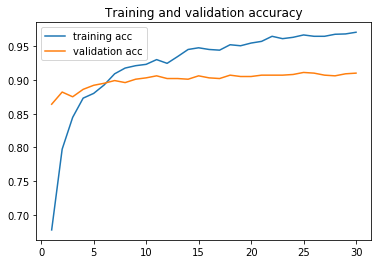

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+ 1)

plt.plot(epochs, acc, label='training acc')
plt.plot (epochs, val_acc, label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

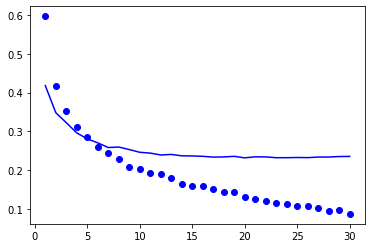

In [25]:
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()